In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
import plotly

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
import os


In [6]:
def build_model(inputs, output_size, neurons, activ_func="tanh",
                dropout=0.20, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

2017-12-13 00:00:00
(3424, 1) (855, 1)
(3424, 1) (3404, 20, 1)
Epoch 1/20
341/341 [==============================] - 6s 11ms/step - loss: 0.0153
Epoch 2/20
341/341 [==============================] - 4s 13ms/step - loss: 0.0110
Epoch 3/20
341/341 [==============================] - 4s 12ms/step - loss: 0.0099
Epoch 4/20
341/341 [==============================] - 4s 12ms/step - loss: 0.0091
Epoch 5/20
341/341 [==============================] - 4s 11ms/step - loss: 0.0094
Epoch 6/20
341/341 [==============================] - 4s 11ms/step - loss: 0.0094
Epoch 7/20
341/341 [==============================] - 4s 11ms/step - loss: 0.0089
Epoch 8/20
341/341 [==============================] - 4s 11ms/step - loss: 0.0089
Epoch 9/20
341/341 [==============================] - 4s 11ms/step - loss: 0.0093
Epoch 10/20
341/341 [==============================] - 4s 12ms/step - loss: 0.0089
Epoch 11/20
341/341 [==============================] - 4s 11ms/step - loss: 0.0095
Epoch 12/20
341/341 [============

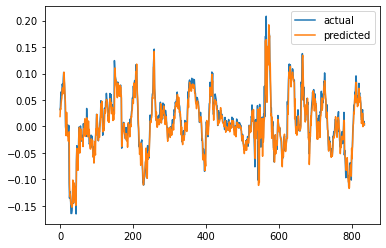

0.000238
0.010448
0.015440
5.798522


In [7]:
path ='../input/row-stocks/WMT.csv'
data = []
df = pd.read_csv(path)
df['Date'] = pd.to_datetime(df['Date'])
data.append(df)

df = data[0]
window_len = 20
day = int(len(df)*0.2)
#Create a data point (i.e. a date) which splits the training and testing set
#split_date = list(data[0]["Date"][-(2*window_len+1):])[0]
split_date = list(data[0]["Date"][-day:])[0]
print(split_date)

#Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','High', 'Low', 'Open','Volume', 'Adj Close'], 1)
test_set = test_set.drop(['Date','High','Low', 'Open','Volume','Adj Close'], 1)
print(training_set.shape, test_set.shape)


#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
    
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
#print(LSTM_training_inputs)
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)
print(training_set.shape, LSTM_training_inputs.shape)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 100)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=20, batch_size=10, verbose=1, shuffle=True)

forecast = nn_model.predict(LSTM_test_inputs)
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(forecast, label = "predicted")
plt.legend()
plt.show()

mse = mean_squared_error(LSTM_test_outputs, forecast)
mae = mean_absolute_error(LSTM_test_outputs, forecast)
rmse = math.sqrt(mean_squared_error(LSTM_test_outputs, forecast))
mape = np.mean(np.abs((forecast - LSTM_test_outputs) / forecast))

print(f'{mse:.6f}')
print(f'{mae:.6f}')
print(f'{rmse:.6f}')
print(f'{mape:.6f}')
